In [1]:
import warnings
warnings.filterwarnings("ignore") 
import pandas as pd 
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.utils import to_categorical
from tensorflow.keras import layers
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

Using TensorFlow backend.


1. Extract the reviews and ratings from the merged data file and make an array list of all the reviews
2. Map the values of rating into postive and negative with threshold >7

In [2]:
df = pd.read_csv(f'Merged_Dataset.csv')
df = df[['Review', 'Rating', 'Drug']]
review = list(df.Review)
labels = np.where(df['Rating']>7, 1, 0)

Checking the review and ratings for few 

In [3]:
for i in range (0, 5):
    print("Review: ", review[i])
    print("Label 1 for Postive and 0 for negative: ", labels[i])
    print('\n')

Review:  "No side effects,  easy to take, no more symptoms since taking."
Label 1 for Postive and 0 for negative:  1


Review:  "I&#039;ve been taking this medicine for a little over 6 months.
I am a 66 yr. old female.  In 2014, I lost 30 pds. on purpose, so I have been feeling good, except age-related pain in my hip joints.
I&#039;ve just realized recently that I&#039;m no longer feeling pain in my joints. Nothing has changed in my life except the addition of this medicine.

So...I&#039;ve concluded this is a POSITIVE side effect from taking this medicine."
Label 1 for Postive and 0 for negative:  1


Review:  "I took ibuprofen (2 caps at night for severe back pain) while taking this medicine and woke in the morning with a severe nose bleed."
Label 1 for Postive and 0 for negative:  0


Review:  "After my VAD Stroke I am on plavix.  I have a toddler that I still nurse. I looked up plavix for several days &amp; talked to several doctors. Some said it was fine, some said it was not ok. 

Defining a function for getting CV and tfID vectors for review analysis

In [4]:
def _tfIDV(list_review):
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(list_review)
    X = X.toarray()
    return X

Using the defined function get the tfID vectors and categorical label encoding

In [5]:
data = _tfIDV(review)
labels = to_categorical(labels, num_classes=2)
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=22, shuffle=False)

Creating a Simple Neural Network using keras API

In [6]:
def _createModel():
    model = tf.keras.Sequential()
    model.add(layers.Dense(25, input_shape=(x_train.shape[1],)))
    model.add(layers.BatchNormalization(momentum=0.8))    
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(25))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(25))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Activation('relu'))
    model.add(layers.Dense(2, activation='softmax'))   
    model.summary()
    return model 

Compiling the model with binary_crossentropy loss function and optimizing with adam optimizer

In [7]:
model = _createModel()
model.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics = ["accuracy"])
hist = model.fit(
    x_train, y_train,
    epochs= 10,
    batch_size = 100,
    validation_data = (x_test, y_test))
print("Avg. Val_Accuracy from sklearn_CV:", np.mean(hist.history["val_acc"]))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 25)                315550    
_________________________________________________________________
batch_normalization (BatchNo (None, 25)                100       
_________________________________________________________________
activation (Activation)      (None, 25)                0         
_________________________________________________________________
dropout (Dropout)            (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                650       
_________________________________________________________________
batch_normalization_1 (Batch (None, 25)                100       
____

Visualizing training loss and accuracy

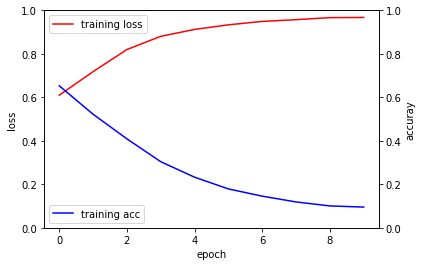

In [8]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.set_ylim([0.0, 1.0])
acc_ax.set_ylim([0.0, 1.0])

loss_ax.plot(hist.history['acc'], 'r', label='training loss')
acc_ax.plot(hist.history['loss'], 'b', label='training acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

Evaluating model performance with scoring metrics

In [9]:
scores = model.evaluate(x_test, y_test, verbose=0)
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
score = precision_recall_fscore_support(y_true, y_pred, average='macro')
print("Evaluation metrics for Sentiment Analysis: ", '\n', "Loss: ", scores[0], '\n'
     , "Accuracy: ", scores[1], '\n', "F1_Score: ", score[2], '\n', "Precision: ", score[0], '\n', 
     "Recall: ", score[1])

Evaluation metrics for Sentiment Analysis:  
 Loss:  0.8925471403015773 
 Accuracy:  0.67047715 
 F1_Score:  0.6676674342456834 
 Precision:  0.683251574187989 
 Recall:  0.6746314581395809


In [10]:
def _posneg(x):
    if x == 0:
        return 'negative'
    if x == 1:
        return 'positive'

Viewing some of the reviews with actual and predicted values

In [11]:
preds = model.predict(x_test[0:5])
preds = np.argmax(preds, axis=1)
y_test = np.argmax(y_test[0:5], axis=1)
d = {'reviews':[review[8048],review[8049],review[8050],review[8051],
               review[8052]], 'actual label': [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]], 
    'predicted label': [preds[0], preds[1], preds[2], preds[3], preds[4]]}
table = pd.DataFrame(data=d)
tableA = table['actual label'].apply(_posneg)
tableP = table['predicted label'].apply(_posneg)
table = table['reviews']
res = pd.concat([table, tableA, tableP], axis=1, sort=False)
print("Some of the reviews and sentiments using d2v embedding")
print('\n')
print(res)
print('\n')

Some of the reviews and sentiments using d2v embedding


                                             reviews actual label  \
0  "I am taking Diamox this is the 3rd time I hav...     positive   
1                               "Works good for me."     negative   
2  "I&#039;ve had glaucoma since I was 9, and I&#...     positive   
3  "I have Iritis, so to get rid of the inflamati...     negative   
4  "It helped lower my pressure but made my eyes ...     negative   

  predicted label  
0        negative  
1        positive  
2        positive  
3        negative  
4        negative  


